In [1]:
import pandas as pd
import matplotlib.pyplot as plt

chemin_fichier_csv = 'DBfinal.csv'
dataset = pd.read_csv(chemin_fichier_csv)

In [2]:
print(dataset.head())

                                                 eng  \
0  The French presentation was a piece of cake fo...   
1  For the professional chef, creating a gourmet ...   
2  Learning to ride a bicycle was a piece of cake...   
3  Managing a team of experienced professionals w...   
4  The science experiment may seem difficult, but...   

                                                  fr  
0  La présentation en français était un jeu d'enf...  
1  Pour le chef professionnel, créer un gâteau go...  
2  Apprendre à faire du vélo était un jeu d'enfan...  
3  Gérer une équipe de professionnels expérimenté...  
4  L'expérience scientifique peut sembler diffici...  


In [3]:
missing_eng_before = dataset['eng'].isna().sum()
missing_fr_before = dataset['fr'].isna().sum()

print(f"Nombre de valeurs manquantes dans la colonne 'eng' avant suppression : {missing_eng_before}")
print(f"Nombre de valeurs manquantes dans la colonne 'fr' avant suppression : {missing_fr_before}")

dataset_cleaned = dataset.dropna(subset=['eng', 'fr'])

missing_eng_after = dataset_cleaned['eng'].isna().sum()
missing_fr_after = dataset_cleaned['fr'].isna().sum()

print(f"Nombre de valeurs manquantes dans la colonne 'eng' après suppression : {missing_eng_after}")
print(f"Nombre de valeurs manquantes dans la colonne 'fr' après suppression : {missing_fr_after}")

Nombre de valeurs manquantes dans la colonne 'eng' avant suppression : 0
Nombre de valeurs manquantes dans la colonne 'fr' avant suppression : 0
Nombre de valeurs manquantes dans la colonne 'eng' après suppression : 0
Nombre de valeurs manquantes dans la colonne 'fr' après suppression : 0


In [4]:
# Calcul de la longueur des phrases en utilisant .loc
dataset_cleaned.loc[:, 'english_length'] = dataset_cleaned['eng'].str.split().apply(len)
dataset_cleaned.loc[:, 'french_length'] = dataset_cleaned['fr'].str.split().apply(len)

# Affichage des statistiques descriptives
print("Statistiques pour l'anglais :")
print(dataset_cleaned['english_length'].describe())
print("\nStatistiques pour le français :")
print(dataset_cleaned['french_length'].describe())



Statistiques pour l'anglais :
count    118387.000000
mean         11.916435
std           4.360699
min           1.000000
25%           9.000000
50%          12.000000
75%          15.000000
max          35.000000
Name: english_length, dtype: float64

Statistiques pour le français :
count    118387.000000
mean         12.660976
std           5.067051
min           1.000000
25%          10.000000
50%          13.000000
75%          16.000000
max          42.000000
Name: french_length, dtype: float64


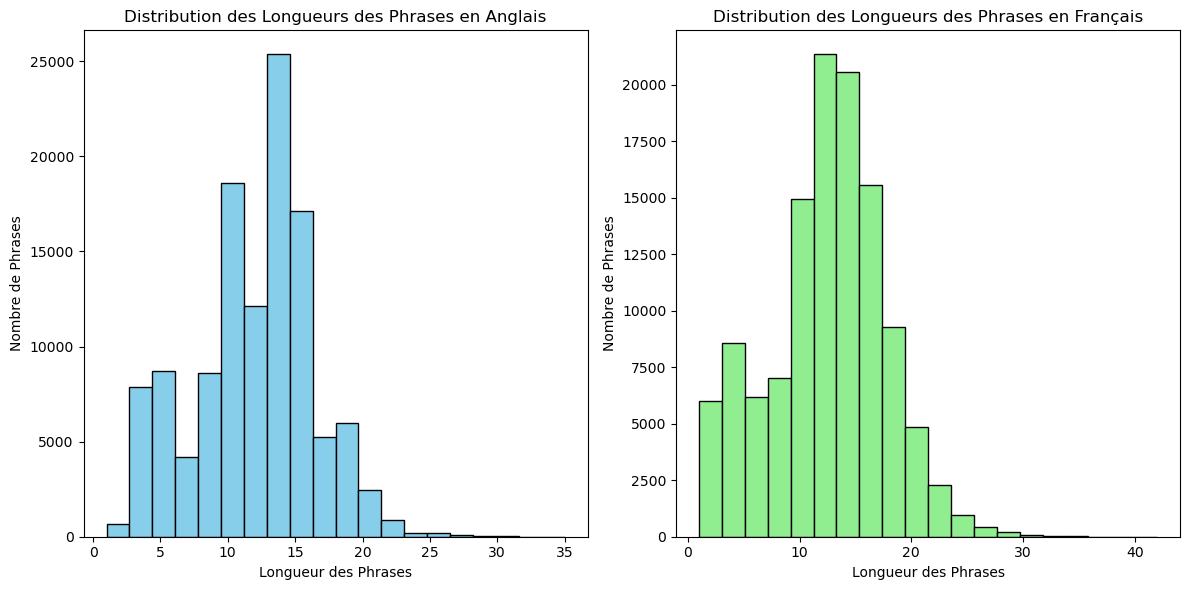

In [5]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)  
plt.hist(dataset_cleaned['english_length'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution des Longueurs des Phrases en Anglais')
plt.xlabel('Longueur des Phrases')
plt.ylabel('Nombre de Phrases')


plt.subplot(1, 2, 2)
plt.hist(dataset_cleaned['french_length'], bins=20, color='lightgreen', edgecolor='black')
plt.title('Distribution des Longueurs des Phrases en Français')
plt.xlabel('Longueur des Phrases')
plt.ylabel('Nombre de Phrases')

plt.tight_layout()
plt.show()


In [9]:
from sklearn.model_selection import train_test_split

# Effectuer le train-test split
train, test = train_test_split(dataset_cleaned, test_size=0.01)

print(f"Taille de l'ensemble d'entraînement: {len(train)}")
print(f"Taille de l'ensemble de test: {len(test)}")


Taille de l'ensemble d'entraînement: 117203
Taille de l'ensemble de test: 1184


In [10]:
from transformers import MarianTokenizer

model_name = "Helsinki-NLP/opus-mt-fr-en"
tokenizer = MarianTokenizer.from_pretrained(model_name)


In [11]:
from datasets import Dataset

train_dataset = Dataset.from_pandas(train)
test_dataset = Dataset.from_pandas(test)

In [12]:
def preprocess_function(examples):
    # Tokenisation des phrases en français
    inputs = tokenizer(examples["fr"], max_length=35, truncation=True, padding="max_length")
    # Tokenisation des traductions en anglais (cibles)
    targets = tokenizer(examples["eng"], max_length=35, truncation=True, padding="max_length")
    return {"input_ids": inputs.input_ids, "attention_mask": inputs.attention_mask, "labels": targets.input_ids}

# Appliquer la fonction de prétraitement aux datasets d'entraînement et de test
tokenized_train_dataset = train_dataset.map(preprocess_function, batched=True)
tokenized_test_dataset = test_dataset.map(preprocess_function, batched=True)


Map:   0%|          | 0/117203 [00:00<?, ? examples/s]

Map:   0%|          | 0/1184 [00:00<?, ? examples/s]

In [13]:
examples = train.sample(5)
print("Exemples de phrases :")
for i, row in examples.iterrows():
    print(f"FR: {row['fr']} -> ENG: {row['eng']}")


print("Tokens des phrases :")
for i, row in examples.iterrows():
    tokens_fr = tokenizer(row['fr'], max_length=128, truncation=True, padding="max_length")
    tokens_eng = tokenizer(row['eng'], max_length=128, truncation=True, padding="max_length")
    tokens_fr_ids = tokens_fr.input_ids
    tokens_eng_ids = tokens_eng.input_ids
    tokens_fr_words = tokenizer.convert_ids_to_tokens(tokens_fr_ids)
    tokens_eng_words = tokenizer.convert_ids_to_tokens(tokens_eng_ids)
    print(f"FR: {row['fr']} -> Tokens FR: {tokens_fr_words}")
    print(f"ENG: {row['eng']} -> Tokens ENG: {tokens_eng_words}")



Exemples de phrases :
FR: Le randonneur s'est perdu dans la forêt dense, mais a finalement trouvé un moyen de s'échapper en suivant la rivière en aval -> ENG: The hiker got lost in the dense forest, but eventually found a way of escaping by following the river downstream
FR: Quand les choses ont commencé à devenir difficiles, il a décidé de prendre la fuite -> ENG: When things got tough, he decided to cut and run
FR: C'était censé être une fête surprise, mais quelqu'un a accidentellement vendu la mèche. -> ENG: It was supposed to be a surprise party, but someone accidentally let the cat out of the bag.
FR: Il a décidé d'accepter l'offre d'emploi qu'il avait déjà au lieu de poursuivre des opportunités potentielles -> ENG: He decided to accept the job offer he already had instead of pursuing potential opportunities
FR: Son explication a été juste, elle a mis le doigt sur le problème, tout est devenu clair. -> ENG: His explanation hit the nail on the head, it made everything clear.
Tokens

In [14]:
from transformers import MarianMTModel, MarianConfig, TrainingArguments, Trainer
import torch

# Configuration et modèle
model_name = "Helsinki-NLP/opus-mt-fr-en"
config = MarianConfig.from_pretrained(model_name)
model = MarianMTModel.from_pretrained(model_name, config=config)

# Vérifier si CUDA est disponible et définir l'appareil
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # Envoyer le modèle sur le GPU si disponible

# Imprimer l'appareil utilisé par le modèle
print(f"Le modèle utilise : {device}")

# Arguments d'entraînement
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=10,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs",
    eval_strategy="epoch",  
    save_strategy="epoch",  
    save_total_limit=3,  
    no_cuda=not torch.cuda.is_available(),  
    dataloader_num_workers=4,  
    dataloader_prefetch_factor=2  
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset, 
    eval_dataset=tokenized_test_dataset   
)

trainer.train()


C:\Users\duody\anaconda3\envs\envforcuda\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Le modèle utilise : cuda


Epoch,Training Loss,Validation Loss
1,0.347900,0.294690
2,0.245200,0.237958
3,0.192600,0.218659
4,0.152800,0.209546
5,0.128500,0.205748
6,0.109000,0.204734
7,0.088300,0.204116
8,0.077000,0.205460
9,0.064600,0.208875
10,0.057100,0.209996


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 512, 'num_beams': 4, 'bad_words_ids': [[59513]], 'forced_eos_token_id': 0}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 512, 'num_beams': 4, 'bad_words_ids': [[59513]], 'forced_eos_token_id': 0}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strate

TrainOutput(global_step=73260, training_loss=0.171840125955326, metrics={'train_runtime': 32282.6773, 'train_samples_per_second': 36.305, 'train_steps_per_second': 2.269, 'total_flos': 1.08636447080448e+16, 'train_loss': 0.171840125955326, 'epoch': 10.0})

In [15]:
tokenizer.save_pretrained('./chemin_de_sauvegarde1')

('./chemin_de_sauvegarde1\\tokenizer_config.json',
 './chemin_de_sauvegarde1\\special_tokens_map.json',
 './chemin_de_sauvegarde1\\vocab.json',
 './chemin_de_sauvegarde1\\source.spm',
 './chemin_de_sauvegarde1\\target.spm',
 './chemin_de_sauvegarde1\\added_tokens.json')

In [1]:
from transformers import MarianMTModel, MarianTokenizer

# Charger le modèle et le tokenizer
model_path = "./resultsFR/checkpoint-73260"  # Remplacez xxxx par le numéro de checkpoint approprié
model = MarianMTModel.from_pretrained(model_path)
tokenizer = MarianTokenizer.from_pretrained(model_path)


def translate(text, model, tokenizer):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512).to(model.device)
    translated_tokens = model.generate(**inputs)
    translated_text = tokenizer.decode(translated_tokens[0], skip_special_tokens=True)
    return translated_text

source_text = "ne me pose pas de lapin"
translated_text = translate(source_text, model, tokenizer)
print(translated_text)

don't stand up to me


In [ ]:
"bon chat bon rat"
"comme en quarante"
"en chier comme un russe"
"jeu d'enfant"
"être aux anges"
"avoir du pain sur la planche"
"être au bout du rouleau"
"calme comme une huitre"
"tomber dans les pommes"
"en faire tout un fromage"
"avoir de la veine"
"Il y a anguille sous roche"
"toucher le pactole"
"il a des fourmis dans les jambes"
"t'as pas le wifi à tous les étages"
"t'es pas le pingouin qui glisse le plus loin sur la banquise."
"t'es pas le couteau le plus aiguisé du tiroir."
"Il en a chié comme un Russe, ce gros projet était réellement compliqué il y avait du pain sur la planche"
"to throw money down the drain"
"Faire mouche"
"il y a une mouche"

In [3]:
model_name = "Helsinki-NLP/opus-mt-fr-en"
tokenizer = MarianTokenizer.from_pretrained(model_name)
model = MarianMTModel.from_pretrained(model_name)

def translate(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    outputs = model.generate(**inputs)
    translated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return translated_text

text = "ne me pose pas un lapin"
translated_text = translate(text)
print("Translated text:", translated_text)


Translated text: Don't put a rabbit on me.
